# Factorization Machine(FM)
우리는 앞에서 MF를 이용해서 사용자의 취향과 아이템의 특성을 나타내는 특성값을 latent vector(잠재요인 벡터)로 만들어서 예측을 수행하였다.
> 엄밀하게 말하자면 여기서는 잠재요인 벡터의 갯수만 지정했지 정확히 어떤 벡터다! 이렇게 지정한 것은 아니다.

하지만 CF에서 그랬던것처럼 사용자의 나이, 성별, 지역과 같은 인구통계 변수나 영화의 특성을 나타내는 여러 변수들이 데이터로 존재한다면 이를 반영하면 더욱 예측에 도움이 될것이다.
위와 같은 다양한 변수들을 종합해서 요인화(Factorization)해주는 방법이 FM이다.
## FM의 표준식
FM의 기본 아이디어는 모든 변수와 그 변수들 간의 상호작용(Interaction)을 고려해서 평점을 예측하는 것이다.
예를 들어서 어떤 영화에 대해서 이전에는 사용자ID, 영화 ID를 사용하였다. 그런데 여기에 더불어서 사용자의 나이, 영화의 상영시간과 같은 데이터가 추가로 있다고 해보자. 그렇다면 각 변수의 상호작용을 모델링 한다면 사용자ID X 상영시간, 영화ID X나이, 상영시간 X나이 등등이 상호작용을 할 것이다. 
> 즉, 모든 변수가 영화의 평점에 미치는 영향을 학습하고 이를 바탕으로 평점을 예측하는 모델이 FM이라고 할 수 있다.

**이런과정을 식으로 나타낸다면 아래와 같다.**
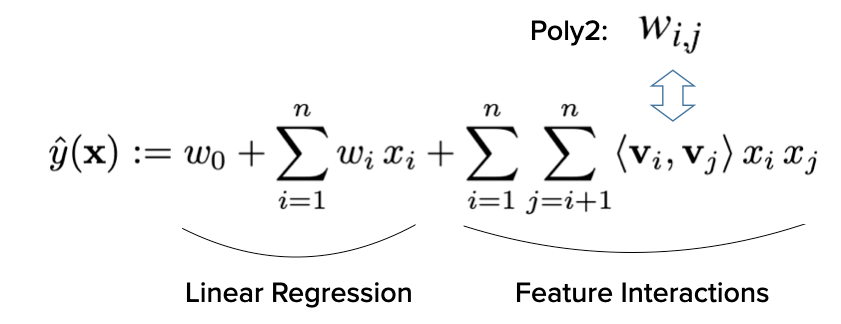

* $w_0$: global bias(전체 편향, 즉 전체평균)
* $w_i$: 입력변수 $x_i$의 편향
* $x_i$: 입력변수
    * **x는 MF처럼 각 사용자나 아이템을 나타내는 것 일수도 있고, 장르나 시간과 같은 별도의 변수 일수도 있다.<br>**
      중요한점은 어떠한 변수이든 간에 하나의 변수에 대해서 하나의 편향값 $w_i$와 k개의 특성값을 갖게 된다. 
      > 만일 x가 사용자와 아이템을 나타내는 one-hot encoding형태로 주어지고 사용자와 아이템 외에 다른 변수가 사용되지 않는다면 위의 식은 결국 MF와 같아진다.
* $v_i$: 잠재요인 행렬 v에서 변수 $x_i$의 특성값
    * 여기서 잠재요인행렬 v는 이전의 MF에서 P나 Q같은 nxk행렬이 된다.

FM의 표준식은 다음과 같이 변형할 수 있다.
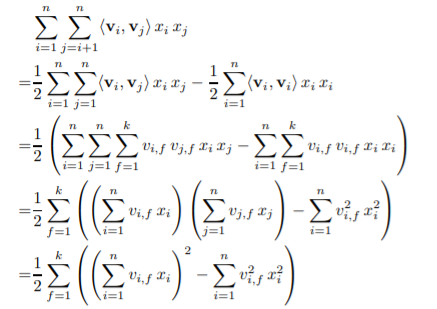

# Sparse Matrix를 Compressed Sparse Row Matrix로 변환하기
* 여기서는 사용자id와 아이템 id만 사용하는 FM의 구현 예를 보인다.

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv('./u.data',sep = '\t', names = r_cols, encoding = 'latin-1')
ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
# User Encoding
user_dict = {}
for i in set(ratings['user_id']):
    user_dict[i] = len(user_dict)
n_user = len(user_dict)
n_user

943

In [4]:
# Item Encoding
item_dict = {}
start_point = n_user
for i in set(ratings['movie_id']):
    item_dict[i] = start_point+len(item_dict)
n_item = len(item_dict)
start_point+=n_item
num_x = start_point # Total number of x
ratings = shuffle(ratings,random_state = 1)

In [8]:
ratings

,user_id,movie_id,rating,timestamp
43660,508,185,5,883777430
87278,518,742,5,876823804
14317,178,28,5,882826806
81932,899,291,4,884122279
95321,115,117,4,881171009
...,...,...,...,...
50057,26,840,2,891386049
98047,625,198,4,891263665
5192,56,568,4,892910797
77708,882,172,5,879864970


In [16]:
# Generate X data
data = []
y = []
w0 = np.mean(ratings['rating'])
for i in range(len(ratings)):
    case = ratings.iloc[i]
    # 초기화
    x_index = []
    x_value = []
    x_index.append(user_dict[case['user_id']])
    x_value.append(1)
    x_index.append(item_dict[case['movie_id']])
    x_value.append(1)
    
    data.append([x_index,x_value])
    y.append(case['rating']-w0)

In [18]:
data

[[[507, 1127], [1, 1]],
 [[517, 1684], [1, 1]],
 [[177, 970], [1, 1]],
 [[898, 1233], [1, 1]],
 [[114, 1059], [1, 1]],
 [[90, 1624], [1, 1]],
 [[5, 1309], [1, 1]],
 [[504, 1069], [1, 1]],
 [[711, 1036], [1, 1]],
 [[270, 1134], [1, 1]],
 [[885, 998], [1, 1]],
 [[933, 1094], [1, 1]],
 [[109, 2171], [1, 1]],
 [[487, 1264], [1, 1]],
 [[170, 1257], [1, 1]],
 [[177, 1402], [1, 1]],
 [[896, 1564], [1, 1]],
 [[786, 1255], [1, 1]],
 [[160, 1074], [1, 1]],
 [[144, 1240], [1, 1]],
 [[248, 1242], [1, 1]],
 [[294, 1602], [1, 1]],
 [[93, 1276], [1, 1]],
 [[488, 1263], [1, 1]],
 [[55, 1530], [1, 1]],
 [[436, 1548], [1, 1]],
 [[610, 1266], [1, 1]],
 [[433, 2037], [1, 1]],
 [[435, 1176], [1, 1]],
 [[621, 1222], [1, 1]],
 [[213, 1404], [1, 1]],
 [[376, 1214], [1, 1]],
 [[757, 1679], [1, 1]],
 [[654, 1960], [1, 1]],
 [[324, 1416], [1, 1]],
 [[58, 1605], [1, 1]],
 [[12, 1505], [1, 1]],
 [[267, 979], [1, 1]],
 [[313, 1743], [1, 1]],
 [[720, 1322], [1, 1]],
 [[825, 1752], [1, 1]],
 [[766, 1105], [1, 1]],
 [

In [22]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

class FM():
    def __init__(self, N, K, data, y, alpha, beta, train_ratio=0.75, iterations=100, tolerance=0.005, l2_reg=True, verbose=True):
        self.K = K          # Number of latent factors
        self.N = N          # Number of x (variables)
        self.n_cases = len(data)            # N of observations
        self.alpha = alpha # 학습률
        self.beta = beta # 정규화 계수
        self.iterations = iterations # 반복 횟수
        self.l2_reg = l2_reg # 정규화를 할지의 여부
        self.tolerance = tolerance # 반복을 중단하는 RMSE의 기준
        self.verbose = verbose
        # w 초기화 : 변수의 편향을 나타낸다
        self.w = np.random.normal(scale=1./self.N, size=(self.N)) # scale은 표준편차를 의미
        # v 초기화 : 잠재요인행렬 v를 초기화
        self.v = np.random.normal(scale=1./self.K, size=(self.N, self.K))
        # Train/Test 분리
        cutoff = int(train_ratio * len(data))
        self.train_x = data[:cutoff]
        self.test_x = data[cutoff:]
        self.train_y = y[:cutoff]
        self.test_y = y[cutoff:]

    def test(self):                                     # Training 하면서 RMSE 계산 
        # SGD를 iterations 숫자만큼 수행
        best_RMSE = 10000
        best_iteration = 0
        training_process = []
        for i in range(self.iterations):
            rmse1 = self.sgd(self.train_x, self.train_y)        # SGD & Train RMSE 계산
            rmse2 = self.test_rmse(self.test_x, self.test_y)    # Test RMSE 계산     
            training_process.append((i, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.6f ; Test RMSE = %.6f" % (i+1, rmse1, rmse2))
            if best_RMSE > rmse2:                       # New best record
                best_RMSE = rmse2
                best_iteration = i
            elif (rmse2 - best_RMSE) > self.tolerance:  # RMSE is increasing over tolerance
                break
        print(best_iteration, best_RMSE)
        return training_process
        
    # w, v 업데이트를 위한 Stochastic gradient descent 
    def sgd(self, x_data, y_data):
        y_pred = []
        for data, y in zip(x_data, y_data):
            x_idx = data[0]             # 형태: [[507, 1127], [1, 1]]
            x_0 = np.array(data[1])     # xi axis=0 [1, 2, 3]
            x_1 = x_0.reshape(-1, 1)    # xi axis=1 [[1], [2], [3]]
    
            # biases
            bias_score = np.sum(self.w[x_idx] * x_0)
    
            # score 계산
            vx = self.v[x_idx] * (x_1)          # v matrix * x
            sum_vx = np.sum(vx, axis=0)         # sigma(vx)
            sum_vx_2 = np.sum(vx * vx, axis=0)  # ( v matrix * x )의 제곱
            latent_score = 0.5 * np.sum(np.square(sum_vx) - sum_vx_2)

            # 예측값 계산
            y_hat = bias_score + latent_score
            y_pred.append(y_hat)
            # error를 다음과 같이 설정하는 이유는 rmse이기 때문이다.
            error = y - y_hat
            # w, v 업데이트 
            if self.l2_reg:     # regularization이 있는 경우
                self.w[x_idx] += error * self.alpha * (x_0 - self.beta * self.w[x_idx])
                self.v[x_idx] += error * self.alpha * ((x_1) * sum(vx) - (vx * x_1) - self.beta * self.v[x_idx])
            else:               # regularization이 없는 경우
                self.w[x_idx] += error * self.alpha * x_0
                self.v[x_idx] += error * self.alpha * ((x_1) * sum(vx) - (vx * x_1))
        return RMSE(y_data, y_pred)

    def test_rmse(self, x_data, y_data):
        y_pred = []
        for data , y in zip(x_data, y_data):
            y_hat = self.predict(data[0], data[1])
            y_pred.append(y_hat)
        return RMSE(y_data, y_pred)

    def predict(self, idx, x):
        x_0 = np.array(x)
        x_1 = x_0.reshape(-1, 1)

        # biases
        bias_score = np.sum(self.w[idx] * x_0)

        # score 계산
        vx = self.v[idx] * (x_1)
        sum_vx = np.sum(vx, axis=0)
        sum_vx_2 = np.sum(vx * vx, axis=0)
        latent_score = 0.5 * np.sum(np.square(sum_vx) - sum_vx_2)

        # 예측값 계산
        y_hat = bias_score + latent_score
        return y_hat

K = 350
fm1 = FM(num_x, K, data, y, alpha=0.0014, beta=0.075, train_ratio=0.75, iterations=600, tolerance=0.0005, l2_reg=True, verbose=True)
result = fm1.test()



Iteration: 10 ; Train RMSE = 0.955976 ; Test RMSE = 0.972692
Iteration: 20 ; Train RMSE = 0.934229 ; Test RMSE = 0.957413
Iteration: 30 ; Train RMSE = 0.925387 ; Test RMSE = 0.951441
Iteration: 40 ; Train RMSE = 0.920596 ; Test RMSE = 0.948419
Iteration: 50 ; Train RMSE = 0.917485 ; Test RMSE = 0.946670
Iteration: 60 ; Train RMSE = 0.914978 ; Test RMSE = 0.945494
Iteration: 70 ; Train RMSE = 0.912260 ; Test RMSE = 0.944450
Iteration: 80 ; Train RMSE = 0.908262 ; Test RMSE = 0.943061
Iteration: 90 ; Train RMSE = 0.901270 ; Test RMSE = 0.940617
Iteration: 100 ; Train RMSE = 0.889183 ; Test RMSE = 0.936399
Iteration: 110 ; Train RMSE = 0.871314 ; Test RMSE = 0.930701
Iteration: 120 ; Train RMSE = 0.848952 ; Test RMSE = 0.924934
Iteration: 130 ; Train RMSE = 0.822616 ; Test RMSE = 0.919889
Iteration: 140 ; Train RMSE = 0.791725 ; Test RMSE = 0.915783
Iteration: 150 ; Train RMSE = 0.756158 ; Test RMSE = 0.912988
Iteration: 160 ; Train RMSE = 0.716746 ; Test RMSE = 0.911848
Iteration: 170 ; 

# 사용자 아이템 외에 추가 데이터까지 사용하는 경우
* 앞에서와 데이터 변환부분만 다르기 때문에 그 부분만 설명한다.

In [25]:
# Load the u.user file into a dataframe
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./u.user', sep='|', names=u_cols, encoding='latin-1')

# Load the u.item file into a dataframe
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('./u.item', sep='|', names=i_cols, encoding='latin-1')

# Load the u.data file into a dataframe
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./u.data', sep='\t', names=r_cols, encoding='latin-1') 

In [26]:
movies

,movie_id,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [28]:
ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [29]:
# User encoding
user_dict = {}
for i in set(users['user_id']):
    user_dict[i] = len(user_dict)
n_user = len(user_dict)
# Item encoding
item_dict = {}
start_point = n_user
for i in set(movies['movie_id']):
    item_dict[i] = start_point + len(item_dict)
n_item = len(item_dict)
start_point += n_item
# Occupation encoding
occ_dict = {}
for i in set(users['occupation']):
    occ_dict[i] = start_point + len(occ_dict)
n_occ = len(occ_dict)
start_point += n_occ
# Gender encoding
gender_dict = {}
for i in set(users['sex']):
    gender_dict[i] = start_point + len(gender_dict)
n_gender = len(gender_dict)
start_point += n_gender
# Genre encoding
genre_dict = {}
genre = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
for i in genre:
    genre_dict[i] = start_point + len(genre_dict)
n_genre = len(genre_dict)
start_point += n_genre
age_index = start_point
start_point += 1
num_x = start_point             # Total number of x
   
# Merge data
movies = movies.drop(['title', 'release date', 'video release date', 'IMDB URL'], axis=1)
users = users.drop(['zip_code'], axis=1)
ratings = ratings.drop(['timestamp'], axis=1)
x = pd.merge(ratings, movies, how='outer', on='movie_id')
x = pd.merge(x, users, how='outer', on='user_id')
x = shuffle(x, random_state=1)

# Generate X data
data = []
y = []
age_mean = np.mean(x['age'])
age_std = np.std(x['age'])
w0 = np.mean(x['rating'])
for i in range(len(x)):
    case = x.iloc[i]
    x_index = []
    x_value = []
    x_index.append(user_dict[case['user_id']])     # User id encoding
    x_value.append(1)
    x_index.append(item_dict[case['movie_id']])    # Movie id encoding
    x_value.append(1)
    x_index.append(occ_dict[case['occupation']])   # Occupation id encoding
    x_value.append(1)
    x_index.append(gender_dict[case['sex']])       # Gender id encoding
    x_value.append(1)
    # 장르는 복수개의 변수가 있으므로 루프를 돌려서 해당되는 장르 모두에 대해 기록
    for j in genre:
        if case[j] == 1:               # 해당 장르가 1 
            x_index.append(genre_dict[j])
            x_value.append(1)
    x_index.append(age_index)
    # 나이는 연속값이므로 정규화한 값을 x_value에 기록한다.
    x_value.append((case['age'] - age_mean) / age_std)
    data.append([x_index, x_value])
    y.append(case['rating'] - w0)
    if (i % 10000) == 0:
        print('Encoding ', i, ' cases...')

Encoding  0  cases...
Encoding  10000  cases...
Encoding  20000  cases...
Encoding  30000  cases...
Encoding  40000  cases...
Encoding  50000  cases...
Encoding  60000  cases...
Encoding  70000  cases...
Encoding  80000  cases...
Encoding  90000  cases...


In [ ]:
K = 200
fm1 = FM(num_x, K, data, y, alpha=0.00005, beta=0.002, train_ratio=0.75, iterations=900, tolerance=0.0001, l2_reg=True, verbose=True)
result = fm1.test()